# ODM 2025 – Exercise Sheet 2: Black-box Service

## VPN Reminder

The black-box service is only available when **connected to the Uni Münster VPN**! Setup instructions can be found here: <https://www.uni-muenster.de/IT/en/services/kommunikation/vpn/index.html>

## General Setup

In [22]:
import requests

In [23]:
class BlackBox:
    """
    This class implements a simple interface to the black-box service for the ODM course.
    """

    def __init__(self, token: int, endpoint: str = 'http://ls-stat-ml.uni-muenster.de:7300/'):
        self.endpoint = endpoint
        self.token = token

    def set_endpoint(self, endpoint: str):
        self.endpoint = endpoint

    def evaluate(self, objective: str, parameters: list) -> float:
        r = requests.post(url=self.endpoint + "compute/" + objective,
                          json={"parameters": [str(v) for v in parameters], "token": self.token})
        return float(r.json())

    def evaluate_gradient(self, objective: str, parameters: list) -> list:
        r = requests.post(url=self.endpoint + "compute_gradient/" + objective,
                          json={"parameters": [str(v) for v in parameters], "token": self.token})
        return r.json()

Remember to change your group number!

In [24]:
# TODO: Change to your group number!
group_number = 1

bb = BlackBox(token = group_number)

## Evaluation Examples

With `bb.evaluate`, you can call the objective function (first argument) on any (two-dimensional) numerical vector (second argument):

In [25]:
y = bb.evaluate("Function1", [0.81, 0.04])
y

0.06577000000000002

With `bb.evaluate_gradient`, you get the gradient of the objective function instead:

In [26]:
grad = bb.evaluate_gradient("Function2", [0.33, 0.44])
grad

[-3.384699045316797, -4.669277486435419]

That is all there is to set up! Now you can use `bb.evaluate` and `bb.evaluate_gradient` to explore and optimize the different black-box functions ...

In [27]:
# Your Code

## Optimization Algorithms Implementation

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### 1. Simple Gradient Descent (Vanilla GD)
# Based on Lecture 04, Slide 27

def gradient_descent(bb, objective, x0, learning_rate=0.01, max_iter=1000, tol=1e-6):
    """
    Simple Gradient Descent optimizer
    
    Formula from lecture: x_{i+1} = x_i - σ · ∇f(x_i)
    
    Parameters:
    -----------
    bb : BlackBox
        Black-box service instance
    objective : str
        Function name ('Function1', 'Function2', etc.)
    x0 : list or np.array
        Starting point [x1, x2]
    learning_rate : float
        Step size σ (sigma)
    max_iter : int
        Maximum number of iterations
    tol : float
        Tolerance for stopping criterion
    
    Returns:
    --------
    dict with:
        - 'x': best solution found
        - 'f': best objective value
        - 'history': list of (x, f) pairs for plotting
        - 'n_evals': number of function evaluations
        - 'n_grad_evals': number of gradient evaluations
    """
    x = np.array(x0, dtype=float)
    history = []
    n_evals = 0
    n_grad_evals = 0
    
    for i in range(max_iter):
        # Evaluate current point
        f_current = bb.evaluate(objective, x.tolist())
        n_evals += 1
        history.append((x.copy(), f_current))
        
        # Get gradient
        grad = np.array(bb.evaluate_gradient(objective, x.tolist()))
        n_grad_evals += 1
        
        # Gradient descent update: x_{i+1} = x_i - σ · ∇f(x_i)
        x_new = x - learning_rate * grad
        
        # Check convergence (gradient magnitude)
        if np.linalg.norm(grad) < tol:
            print(f"Converged after {i+1} iterations (gradient norm < {tol})")
            break
            
        x = x_new
    
    # Final evaluation
    f_final = bb.evaluate(objective, x.tolist())
    n_evals += 1
    
    return {
        'x': x,
        'f': f_final,
        'history': history,
        'n_evals': n_evals,
        'n_grad_evals': n_grad_evals,
        'iterations': len(history)
    }

---

## Run Experiments

In [28]:
### 2. Momentum Search
# Based on Lecture 04, Slide 32

def momentum_search(bb, objective, x0, learning_rate=0.01, beta=0.9, max_iter=1000, tol=1e-6):
    """
    Momentum Search optimizer
    
    Formulas from lecture (Slide 32):
        v_i = β · v_{i-1} + (1 - β) · ∇f(x_i)
        x_{i+1} = x_i - σ · v_i
    
    Combines previous velocity with current gradient for smoother updates.
    Helps prevent zig-zagging and can accelerate convergence.
    
    Parameters:
    -----------
    bb : BlackBox
        Black-box service instance
    objective : str
        Function name ('Function1', 'Function2', etc.)
    x0 : list or np.array
        Starting point [x1, x2]
    learning_rate : float
        Step size σ (sigma)
    beta : float
        Momentum coefficient (usually 0.9)
    max_iter : int
        Maximum number of iterations
    tol : float
        Tolerance for stopping criterion
    
    Returns:
    --------
    dict with optimization results
    """
    x = np.array(x0, dtype=float)
    v = np.zeros_like(x)  # Initialize velocity to zero
    history = []
    n_evals = 0
    n_grad_evals = 0
    
    for i in range(max_iter):
        # Evaluate current point
        f_current = bb.evaluate(objective, x.tolist())
        n_evals += 1
        history.append((x.copy(), f_current))
        
        # Get gradient
        grad = np.array(bb.evaluate_gradient(objective, x.tolist()))
        n_grad_evals += 1
        
        # Momentum update: v_i = β · v_{i-1} + (1 - β) · ∇f(x_i)
        v = beta * v + (1 - beta) * grad
        
        # Position update: x_{i+1} = x_i - σ · v_i
        x_new = x - learning_rate * v
        
        # Check convergence (gradient magnitude)
        if np.linalg.norm(grad) < tol:
            print(f"Converged after {i+1} iterations (gradient norm < {tol})")
            break
            
        x = x_new
    
    # Final evaluation
    f_final = bb.evaluate(objective, x.tolist())
    n_evals += 1
    
    return {
        'x': x,
        'f': f_final,
        'history': history,
        'n_evals': n_evals,
        'n_grad_evals': n_grad_evals,
        'iterations': len(history)
    }

In [29]:
### 3. RMSProp (Root Mean Square Propagation)
# Based on Lecture 04, Slide 35

def rmsprop(bb, objective, x0, learning_rate=0.01, beta=0.9, epsilon=1e-8, max_iter=1000, tol=1e-6):
    """
    RMSProp optimizer - adapts learning rate based on gradient magnitude
    
    Formulas from lecture (Slide 35):
        E[∇f(x_i)²] = β · E[∇f(x_{i-1})²] + (1 - β) · ∇f(x_i)²
        σ_hat = σ / √(E[∇f(x_i)²] + ε)
        x_{i+1} = x_i - σ_hat · ∇f(x_i)
    
    Parameters:
    -----------
    beta : float
        Decay rate for squared gradient moving average (usually 0.9)
    epsilon : float
        Small constant to avoid division by zero (usually 1e-8)
    """
    x = np.array(x0, dtype=float)
    E_grad_sq = np.zeros_like(x)  # Moving average of squared gradients
    history = []
    n_evals = 0
    n_grad_evals = 0
    
    for i in range(max_iter):
        # Evaluate current point
        f_current = bb.evaluate(objective, x.tolist())
        n_evals += 1
        history.append((x.copy(), f_current))
        
        # Get gradient
        grad = np.array(bb.evaluate_gradient(objective, x.tolist()))
        n_grad_evals += 1
        
        # Update moving average of squared gradients
        E_grad_sq = beta * E_grad_sq + (1 - beta) * grad**2
        
        # Adaptive learning rate
        lr_adapted = learning_rate / (np.sqrt(E_grad_sq) + epsilon)
        
        # Update position
        x_new = x - lr_adapted * grad
        
        # Check convergence
        if np.linalg.norm(grad) < tol:
            print(f"Converged after {i+1} iterations (gradient norm < {tol})")
            break
            
        x = x_new
    
    f_final = bb.evaluate(objective, x.tolist())
    n_evals += 1
    
    return {
        'x': x,
        'f': f_final,
        'history': history,
        'n_evals': n_evals,
        'n_grad_evals': n_grad_evals,
        'iterations': len(history)
    }

In [30]:
### 4. Adam Optimizer
# Based on Lecture 04, Slide 39

def adam(bb, objective, x0, learning_rate=0.01, beta1=0.9, beta2=0.999, epsilon=1e-8, max_iter=1000, tol=1e-6):
    """
    Adam (Adaptive Moment Estimation) optimizer
    Combines Momentum + RMSProp
    
    Formulas from lecture (Slide 39):
        m_i = β₁ · m_{i-1} + (1 - β₁) · g_i              (1st moment - mean)
        v_i = β₂ · v_{i-1} + (1 - β₂) · g_i²             (2nd moment - variance)
        m_hat_i = m_i / (1 - β₁ᵗ)                        (bias correction)
        v_hat_i = v_i / (1 - β₂ᵗ)                        (bias correction)
        x_i = x_{i-1} - (σ / √(v_hat_i + ε)) · m_hat_i
    
    Parameters:
    -----------
    beta1 : float
        Decay rate for 1st moment (usually 0.9)
    beta2 : float
        Decay rate for 2nd moment (usually 0.999)
    epsilon : float
        Small constant for numerical stability (usually 1e-8)
    """
    x = np.array(x0, dtype=float)
    m = np.zeros_like(x)  # 1st moment (mean of gradients)
    v = np.zeros_like(x)  # 2nd moment (variance of gradients)
    history = []
    n_evals = 0
    n_grad_evals = 0
    
    for t in range(1, max_iter + 1):
        # Evaluate current point
        f_current = bb.evaluate(objective, x.tolist())
        n_evals += 1
        history.append((x.copy(), f_current))
        
        # Get gradient
        grad = np.array(bb.evaluate_gradient(objective, x.tolist()))
        n_grad_evals += 1
        
        # Update biased 1st moment estimate
        m = beta1 * m + (1 - beta1) * grad
        
        # Update biased 2nd moment estimate
        v = beta2 * v + (1 - beta2) * grad**2
        
        # Bias correction
        m_hat = m / (1 - beta1**t)
        v_hat = v / (1 - beta2**t)
        
        # Update parameters
        x_new = x - (learning_rate / (np.sqrt(v_hat) + epsilon)) * m_hat
        
        # Check convergence
        if np.linalg.norm(grad) < tol:
            print(f"Converged after {t} iterations (gradient norm < {tol})")
            break
            
        x = x_new
    
    f_final = bb.evaluate(objective, x.tolist())
    n_evals += 1
    
    return {
        'x': x,
        'f': f_final,
        'history': history,
        'n_evals': n_evals,
        'n_grad_evals': n_grad_evals,
        'iterations': len(history)
    }

In [31]:
### 5. Coordinate Search
# Based on Lecture 05, Slide 5

def coordinate_search(bb, objective, x0, step_size=0.1, alpha=0.9, max_iter=1000, tol=1e-6):
    """
    Coordinate Search - searches along coordinate axes
    
    Algorithm from Lecture 05, Slide 5:
        For each dimension i:
            Try x + σ·b_i (move forward along axis i)
            If not better, try x - σ·b_i (move backward)
            If still not better, keep x
        After trying all dimensions, reduce step size: σ = α·σ
    
    Parameters:
    -----------
    step_size : float
        Initial step size σ
    alpha : float
        Step size reduction factor (usually 0.9)
    """
    x = np.array(x0, dtype=float)
    sigma = step_size
    n = len(x)
    history = []
    n_evals = 0
    
    for epoch in range(max_iter):
        # Evaluate current point
        f_current = bb.evaluate(objective, x.tolist())
        n_evals += 1
        history.append((x.copy(), f_current))
        
        improved = False
        
        # Try each coordinate axis
        for i in range(n):
            # Create basis vector for dimension i
            basis = np.zeros(n)
            basis[i] = 1.0
            
            # Try positive direction
            x_plus = x + sigma * basis
            f_plus = bb.evaluate(objective, x_plus.tolist())
            n_evals += 1
            
            if f_plus < f_current:
                x = x_plus
                f_current = f_plus
                improved = True
            else:
                # Try negative direction
                x_minus = x - sigma * basis
                f_minus = bb.evaluate(objective, x_minus.tolist())
                n_evals += 1
                
                if f_minus < f_current:
                    x = x_minus
                    f_current = f_minus
                    improved = True
        
        # Reduce step size
        sigma = alpha * sigma
        
        # Check convergence
        if sigma < tol:
            print(f"Converged after {epoch+1} epochs (step size < {tol})")
            break
    
    return {
        'x': x,
        'f': f_current,
        'history': history,
        'n_evals': n_evals,
        'n_grad_evals': 0,  # Doesn't use gradients!
        'iterations': len(history)
    }

In [32]:
### 6. Hooke & Jeeves Pattern Search
# Based on Lecture 05, Slides 8-9

def hooke_jeeves(bb, objective, x0, step_size=0.5, alpha=0.5, max_iter=1000, tol=1e-6):
    """
    Hooke & Jeeves Pattern Search
    
    Extension of coordinate search that "learns" patterns:
        1. Explore around base point (coordinate search) → x'
        2. If successful: pattern move from x to x' → y
        3. Explore around y → z
        4. If z better than x': continue with new pattern
        5. Otherwise: fallback to x' and explore
    
    Parameters:
    -----------
    step_size : float
        Initial exploration step size
    alpha : float
        Step size reduction factor
    """
    x_base = np.array(x0, dtype=float)
    sigma = step_size
    n = len(x_base)
    history = []
    n_evals = 0
    
    def explore(x_start, sigma):
        """Coordinate search exploration around a point"""
        x = x_start.copy()
        f_current = bb.evaluate(objective, x.tolist())
        nonlocal n_evals
        n_evals += 1
        
        for i in range(n):
            basis = np.zeros(n)
            basis[i] = 1.0
            
            # Try positive direction
            x_plus = x + sigma * basis
            f_plus = bb.evaluate(objective, x_plus.tolist())
            n_evals += 1
            
            if f_plus < f_current:
                x = x_plus
                f_current = f_plus
            else:
                # Try negative direction
                x_minus = x - sigma * basis
                f_minus = bb.evaluate(objective, x_minus.tolist())
                n_evals += 1
                
                if f_minus < f_current:
                    x = x_minus
                    f_current = f_minus
        
        return x, f_current
    
    for iteration in range(max_iter):
        # Evaluate base point
        f_base = bb.evaluate(objective, x_base.tolist())
        n_evals += 1
        history.append((x_base.copy(), f_base))
        
        # Exploratory move around base
        x_explore, f_explore = explore(x_base, sigma)
        
        if f_explore < f_base:
            # Success! Try pattern move
            pattern = x_explore - x_base
            x_pattern = x_explore + pattern
            
            # Explore around pattern point
            x_new, f_new = explore(x_pattern, sigma)
            
            if f_new < f_explore:
                # Pattern move successful
                x_base = x_new
            else:
                # Pattern move failed, use exploratory result
                x_base = x_explore
        else:
            # No improvement, reduce step size
            sigma = alpha * sigma
            
            if sigma < tol:
                print(f"Converged after {iteration+1} iterations (step size < {tol})")
                break
    
    f_final = bb.evaluate(objective, x_base.tolist())
    n_evals += 1
    
    return {
        'x': x_base,
        'f': f_final,
        'history': history,
        'n_evals': n_evals,
        'n_grad_evals': 0,  # Doesn't use gradients!
        'iterations': len(history)
    }

In [33]:
### 7. Nelder-Mead Simplex (from scipy)
# Based on Lecture 05, Slides 14-17

from scipy.optimize import minimize

def nelder_mead(bb, objective, x0, max_iter=1000, tol=1e-6):
    """
    Nelder-Mead Simplex Search (using scipy implementation)
    
    Uses simplex (triangle in 2D) that reflects, expands, and contracts
    to find the minimum. From Lecture 05, Slides 14-17.
    
    Parameters:
    -----------
    bb : BlackBox
        Black-box service instance
    objective : str
        Function name
    x0 : list or np.array
        Starting point
    """
    x0 = np.array(x0, dtype=float)
    n_evals = [0]  # Use list to modify in nested function
    history = []
    
    def objective_func(x):
        """Wrapper to track evaluations"""
        f = bb.evaluate(objective, x.tolist())
        n_evals[0] += 1
        history.append((x.copy(), f))
        return f
    
    # Run scipy's Nelder-Mead
    result = minimize(
        objective_func,
        x0,
        method='Nelder-Mead',
        options={'maxiter': max_iter, 'xatol': tol, 'fatol': tol}
    )
    
    return {
        'x': result.x,
        'f': result.fun,
        'history': history,
        'n_evals': n_evals[0],
        'n_grad_evals': 0,  # Doesn't use gradients!
        'iterations': len(history),
        'success': result.success
    }

---

## Experiment Configuration

All parameters in one place for easy tuning:

In [34]:
# ============================================================
# EXPERIMENT CONFIGURATION - Change parameters here!
# ============================================================

# Global parameters
MAX_ITERATIONS = 500
TOLERANCE = 1e-6

# Optimizer-specific parameters
OPTIMIZER_PARAMS = {
    # Gradient-based methods
    'Gradient Descent': {'learning_rate': 0.01},
    'Momentum': {'learning_rate': 0.05, 'beta': 0.95},
    'RMSProp': {'learning_rate': 0.05, 'beta': 0.95, 'epsilon': 1e-8},
    'Adam': {'learning_rate': 0.02, 'beta1': 0.9, 'beta2': 0.999, 'epsilon': 1e-8},
    
    # Gradient-free methods
    'Coordinate Search': {'step_size': 0.2, 'alpha': 0.85},
    'Hooke & Jeeves': {'step_size': 0.3, 'alpha': 0.6},
    'Nelder-Mead': {}  # Uses default scipy settings
}

# Define all optimizers
optimizers = {
    'Gradient Descent': gradient_descent,
    'Momentum': momentum_search,
    'RMSProp': rmsprop,
    'Adam': adam,
    'Coordinate Search': coordinate_search,
    'Hooke & Jeeves': hooke_jeeves,
    'Nelder-Mead': nelder_mead
}

# Define all test functions
functions = ['Function1', 'Function2', 'Function3', 'Function4', 'Function5']

# Starting points to test (for sensitivity analysis - Exercise 2.2 question 4)
starting_points = [
    [0.0, 0.0],    # Origin
    [2.0, 2.0],    # Positive quadrant
    [-2.0, -2.0],  # Negative quadrant
    [3.0, -3.0],   # Mixed
]

print("=" * 70)
print("EXPERIMENT CONFIGURATION")
print("=" * 70)
print(f"Optimizers: {len(optimizers)}")
print(f"Functions: {len(functions)}")
print(f"Starting points: {len(starting_points)}")
print(f"Max iterations: {MAX_ITERATIONS}")
print(f"Tolerance: {TOLERANCE}")
print(f"\nTotal experiments: {len(optimizers)} × {len(functions)} × {len(starting_points)} = {len(optimizers) * len(functions) * len(starting_points)}")
print("=" * 70)

EXPERIMENT CONFIGURATION
Optimizers: 7
Functions: 5
Starting points: 4
Max iterations: 500
Tolerance: 1e-06

Total experiments: 7 × 5 × 4 = 140


### Run All Experiments

This will run all 7 optimizers on all 5 functions with multiple starting points:

In [35]:
def run_all_experiments(bb, optimizers, functions, starting_points, optimizer_params, max_iter=500, tol=1e-6):
    """
    Run all optimizer × function × starting_point combinations
    
    Parameters:
    -----------
    optimizer_params : dict
        Dictionary with parameters for each optimizer
    
    Returns:
    --------
    results : list of dicts
        Each dict contains: optimizer_name, function_name, start_point, result
    """
    results = []
    total_experiments = len(optimizers) * len(functions) * len(starting_points)
    experiment_count = 0
    
    print(f"Starting {total_experiments} experiments...")
    print("=" * 70)
    
    for func_name in functions:
        print(f"\n{'='*70}")
        print(f"Testing on {func_name}")
        print(f"{'='*70}")
        
        for start_idx, x0 in enumerate(starting_points):
            print(f"\n  Starting point {start_idx+1}/{len(starting_points)}: {x0}")
            
            for opt_name, opt_func in optimizers.items():
                experiment_count += 1
                
                try:
                    # Get optimizer-specific parameters
                    params = optimizer_params.get(opt_name, {}).copy()
                    params['max_iter'] = max_iter
                    params['tol'] = tol
                    
                    # Run optimizer
                    result = opt_func(bb, func_name, x0, **params)
                    
                    results.append({
                        'optimizer': opt_name,
                        'function': func_name,
                        'start_point': x0.copy() if isinstance(x0, np.ndarray) else x0,
                        'final_x': result['x'],
                        'final_f': result['f'],
                        'iterations': result['iterations'],
                        'n_evals': result['n_evals'],
                        'n_grad_evals': result['n_grad_evals'],
                        'total_api_calls': result['n_evals'] + result['n_grad_evals'],
                        'history': result['history'],
                        'success': True
                    })
                    
                    print(f"    [{experiment_count:3d}/{total_experiments}] {opt_name:20s} → f={result['f']:.6f} (iters={result['iterations']:3d}, calls={result['n_evals'] + result['n_grad_evals']:4d})")
                    
                except Exception as e:
                    print(f"    [{experiment_count:3d}/{total_experiments}] {opt_name:20s} → FAILED: {str(e)}")
                    results.append({
                        'optimizer': opt_name,
                        'function': func_name,
                        'start_point': x0,
                        'success': False,
                        'error': str(e)
                    })
    
    print(f"\n{'='*70}")
    print(f"✅ Completed {len([r for r in results if r.get('success', False)])} / {total_experiments} experiments successfully!")
    print(f"{'='*70}")
    
    return results

In [36]:
def create_comparison_matrices(results):
    """
    Create comparison matrices and summary statistics
    
    Returns DataFrames for:
    - Best objective values (Function × Optimizer)
    - Number of iterations (Function × Optimizer)
    - Total API calls (Function × Optimizer)
    """
    # Filter successful results
    successful = [r for r in results if r.get('success', False)]
    
    # Create DataFrame
    df = pd.DataFrame(successful)
    
    # For each function, find best result per optimizer (averaged over starting points)
    matrices = {}
    
    # 1. Best objective value matrix
    pivot_obj = df.groupby(['function', 'optimizer'])['final_f'].mean().unstack()
    matrices['objective_values'] = pivot_obj
    
    # 2. Iterations matrix
    pivot_iter = df.groupby(['function', 'optimizer'])['iterations'].mean().unstack()
    matrices['iterations'] = pivot_iter
    
    # 3. Total API calls matrix
    pivot_calls = df.groupby(['function', 'optimizer'])['total_api_calls'].mean().unstack()
    matrices['api_calls'] = pivot_calls
    
    # 4. Success rate (how often did optimizer find good solution)
    matrices['dataframe'] = df
    
    return matrices

def display_matrices(matrices):
    """Display comparison matrices nicely"""
    
    print("\n" + "=" * 70)
    print("COMPARISON MATRIX 1: Best Objective Values (lower is better)")
    print("=" * 70)
    print(matrices['objective_values'].to_string())
    
    print("\n" + "=" * 70)
    print("COMPARISON MATRIX 2: Average Iterations")
    print("=" * 70)
    print(matrices['iterations'].to_string())
    
    print("\n" + "=" * 70)
    print("COMPARISON MATRIX 3: Total API Calls")
    print("=" * 70)
    print(matrices['api_calls'].to_string())
    
    # Find best optimizer for each function
    print("\n" + "=" * 70)
    print("BEST OPTIMIZER PER FUNCTION")
    print("=" * 70)
    best_per_func = matrices['objective_values'].idxmin(axis=1)
    for func, best_opt in best_per_func.items():
        best_val = matrices['objective_values'].loc[func, best_opt]
        print(f"{func}: {best_opt:20s} (f = {best_val:.6f})")
    
    return matrices

In [37]:
# OPTION 1: Quick test with just Function1 (recommended first!)
print("Quick test with Function1 only...")
test_results = run_all_experiments(
    bb=bb,
    optimizers=optimizers,
    functions=['Function1'],  # Just one function
    starting_points=[[3.0, -2.5]],  # Start AWAY from optimum!
    optimizer_params=OPTIMIZER_PARAMS,  # Use central config
    max_iter=100,
    tol=TOLERANCE
)

Quick test with Function1 only...
Starting 7 experiments...

Testing on Function1

  Starting point 1/1: [3.0, -2.5]
    [  1/7] Gradient Descent     → f=1.021829 (iters=100, calls= 201)
    [  2/7] Momentum             → f=0.226950 (iters=100, calls= 201)
    [  3/7] RMSProp              → f=0.000001 (iters=100, calls= 201)
    [  4/7] Adam                 → f=0.233579 (iters=100, calls= 201)
Converged after 76 epochs (step size < 1e-06)
    [  5/7] Coordinate Search    → f=0.413892 (iters= 76, calls= 304)
Converged after 45 iterations (step size < 1e-06)
    [  6/7] Hooke & Jeeves       → f=0.000000 (iters= 45, calls= 349)
    [  7/7] Nelder-Mead          → f=0.000000 (iters=114, calls= 114)

✅ Completed 7 / 7 experiments successfully!


In [38]:
# Display comparison matrices
matrices = create_comparison_matrices(test_results)
display_matrices(matrices)


COMPARISON MATRIX 1: Best Objective Values (lower is better)
optimizer      Adam  Coordinate Search  Gradient Descent  Hooke & Jeeves  Momentum   Nelder-Mead       RMSProp
function                                                                                                      
Function1  0.233579           0.413892          1.021829    2.170483e-14   0.22695  2.151924e-14  5.914678e-07

COMPARISON MATRIX 2: Average Iterations
optimizer   Adam  Coordinate Search  Gradient Descent  Hooke & Jeeves  Momentum  Nelder-Mead  RMSProp
function                                                                                             
Function1  100.0               76.0             100.0            45.0     100.0        114.0    100.0

COMPARISON MATRIX 3: Total API Calls
optimizer   Adam  Coordinate Search  Gradient Descent  Hooke & Jeeves  Momentum  Nelder-Mead  RMSProp
function                                                                                             
Function1  201.0

{'objective_values': optimizer      Adam  Coordinate Search  Gradient Descent  Hooke & Jeeves  \
 function                                                                   
 Function1  0.233579           0.413892          1.021829    2.170483e-14   
 
 optimizer  Momentum   Nelder-Mead       RMSProp  
 function                                         
 Function1   0.22695  2.151924e-14  5.914678e-07  ,
 'iterations': optimizer   Adam  Coordinate Search  Gradient Descent  Hooke & Jeeves  \
 function                                                                
 Function1  100.0               76.0             100.0            45.0   
 
 optimizer  Momentum  Nelder-Mead  RMSProp  
 function                                   
 Function1     100.0        114.0    100.0  ,
 'api_calls': optimizer   Adam  Coordinate Search  Gradient Descent  Hooke & Jeeves  \
 function                                                                
 Function1  201.0              304.0             201.0    

In [102]:
# OPTION 2: Full experiment - ALL functions, ALL starting points

print("\n" + "="*70)
print("RUNNING FULL EXPERIMENT")
print("="*70)
full_results = run_all_experiments(
    bb=bb,
    optimizers=optimizers,
    functions=functions,  # All 5 functions
    starting_points=starting_points,  # All 4 starting points
    optimizer_params=OPTIMIZER_PARAMS,
    max_iter=MAX_ITERATIONS,
    tol=TOLERANCE
)

# Save results to file (optional)
import pickle
with open('full_results.pkl', 'wb') as f:
    pickle.dump(full_results, f)
print("✅ Results saved to full_results.pkl")


RUNNING FULL EXPERIMENT
Starting 140 experiments...

Testing on Function1

  Starting point 1/4: [0.0, 0.0]
Converged after 1 iterations (gradient norm < 1e-06)
    [  1/140] Gradient Descent     → f=0.000000 (iters=  1, calls=   3)
Converged after 1 iterations (gradient norm < 1e-06)
    [  2/140] Momentum             → f=0.000000 (iters=  1, calls=   3)
Converged after 1 iterations (gradient norm < 1e-06)
    [  3/140] RMSProp              → f=0.000000 (iters=  1, calls=   3)
Converged after 1 iterations (gradient norm < 1e-06)
    [  4/140] Adam                 → f=0.000000 (iters=  1, calls=   3)
Converged after 76 epochs (step size < 1e-06)
    [  5/140] Coordinate Search    → f=0.000000 (iters= 76, calls= 380)
Converged after 25 iterations (step size < 1e-06)
    [  6/140] Hooke & Jeeves       → f=0.000000 (iters= 25, calls= 151)
    [  7/140] Nelder-Mead          → f=0.000000 (iters= 37, calls=  37)

  Starting point 2/4: [2.0, 2.0]
    [  8/140] Gradient Descent     → f=0.1080


COMPARISON MATRIX 1: Best Objective Values (lower is better)
optimizer          Adam  Coordinate Search  Gradient Descent  Hooke & Jeeves  Momentum   Nelder-Mead       RMSProp
function                                                                                                          
Function1  1.323446e-08           0.183335      1.148048e-01    2.170483e-14  0.000003  7.019806e-15  8.912979e-13
Function2  9.457132e-01           0.895965      9.457132e-01    8.959654e-01  0.945713  9.457132e-01  9.702637e-01
Function3  3.873819e-01           3.502602     1.282126e+116    2.360567e-01  0.119765  1.000000e-01  3.556992e-01
Function4  1.000003e-01          18.440692      1.000000e-01    1.000000e-01  0.100000  1.000000e-01  1.104178e-01
Function5  7.955144e-01           0.795397      7.955012e-01    7.953971e-01  0.795443  8.496547e-01  7.999478e-01

COMPARISON MATRIX 2: Average Iterations
optimizer    Adam  Coordinate Search  Gradient Descent  Hooke & Jeeves  Momentum  Nelder-Mea

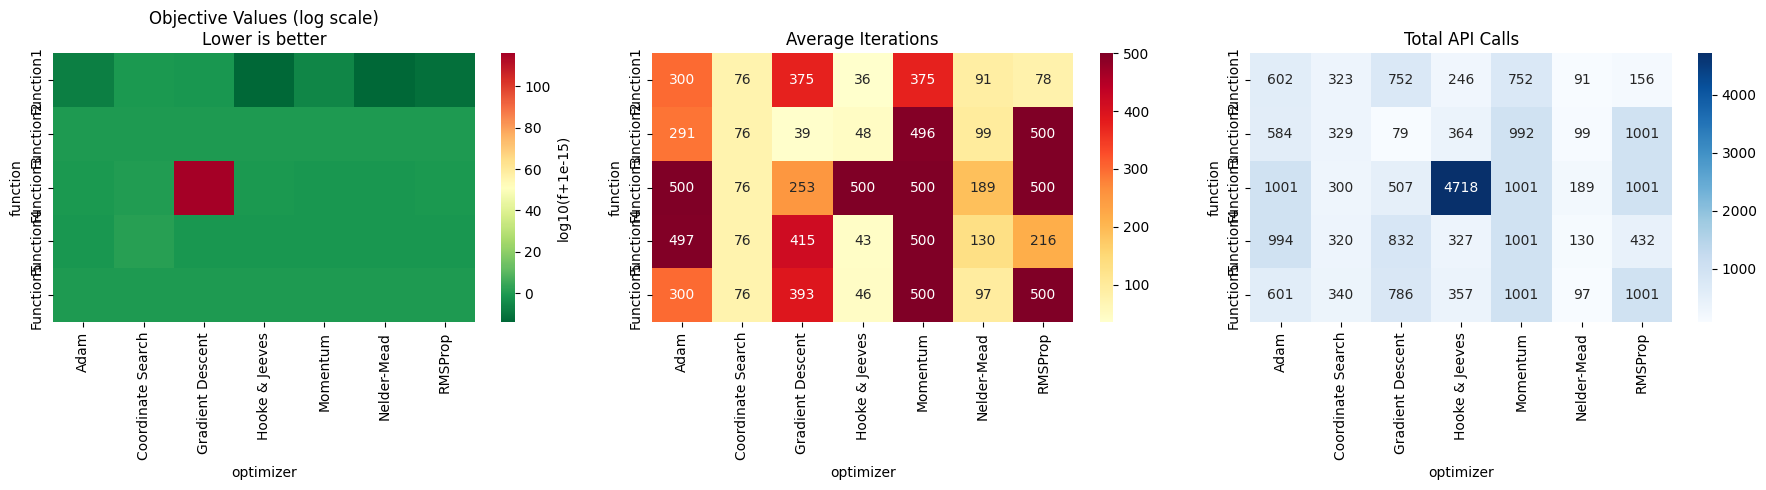

In [103]:
# Display full results (after running full experiment)
# Uncomment after full_results is available:

matrices_full = create_comparison_matrices(full_results)
display_matrices(matrices_full)

# # Better formatted display with heatmap
import seaborn as sns
# 
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
# 
# # 1. Objective values heatmap (use log scale for diverged values)
obj_matrix = matrices_full['objective_values'].copy()
# # Cap at reasonable value to see patterns
obj_matrix_display = np.log10(obj_matrix + 1e-15)  # Log scale
sns.heatmap(obj_matrix_display, annot=False, cmap='RdYlGn_r', ax=axes[0], cbar_kws={'label': 'log10(f+1e-15)'})
axes[0].set_title('Objective Values (log scale)\nLower is better')
# 
# # 2. Iterations
sns.heatmap(matrices_full['iterations'], annot=True, fmt='.0f', cmap='YlOrRd', ax=axes[1])
axes[1].set_title('Average Iterations')
# 
# # 3. API Calls
sns.heatmap(matrices_full['api_calls'], annot=True, fmt='.0f', cmap='Blues', ax=axes[2])
axes[2].set_title('Total API Calls')
# 
plt.tight_layout()
plt.show()

In [104]:
# Detailed Analysis of Results
# Run this after full experiment completes

def analyze_results(matrices):
    """
    Analyze results and answer Exercise 2.2 questions
    """
    df = matrices['dataframe']
    obj_values = matrices['objective_values']
    
    print("=" * 70)
    print("EXERCISE 2.2 ANALYSIS - Answering the Questions")
    print("=" * 70)
    
    # Question 1: Are there problems favoring a particular optimizer?
    print("\n🔍 Question 1: Problems favoring particular optimizers?")
    print("-" * 70)
    for func in obj_values.index:
        best_opt = obj_values.loc[func].idxmin()
        best_val = obj_values.loc[func, best_opt]
        worst_opt = obj_values.loc[func].idxmax()
        worst_val = obj_values.loc[func, worst_opt]
        
        print(f"\n{func}:")
        print(f"  ✅ Best:  {best_opt:20s} f={best_val:.2e}")
        print(f"  ❌ Worst: {worst_opt:20s} f={worst_val:.2e}")
        
        # Check for divergence (very large values)
        if worst_val > 1e10:
            print(f"  ⚠️  WARNING: {worst_opt} DIVERGED!")
    
    # Question 2: How to compare results?
    print("\n\n📊 Question 2: How to compare results between optimizers?")
    print("-" * 70)
    print("We use three metrics:")
    print("  1. Final objective value (solution quality)")
    print("  2. Number of iterations (convergence speed)")
    print("  3. Total API calls (computational cost)")
    
    # Question 3: Fair comparison gradient vs non-gradient
    print("\n\n⚖️  Question 3: Fair comparison gradient vs non-gradient?")
    print("-" * 70)
    
    # Separate by type
    gradient_based = ['Gradient Descent', 'Momentum', 'RMSProp', 'Adam']
    gradient_free = ['Coordinate Search', 'Hooke & Jeeves', 'Nelder-Mead']
    
    print("\nAverage API calls:")
    for func in obj_values.index:
        func_data = df[df['function'] == func]
        grad_calls = func_data[func_data['optimizer'].isin(gradient_based)]['total_api_calls'].mean()
        free_calls = func_data[func_data['optimizer'].isin(gradient_free)]['total_api_calls'].mean()
        
        print(f"  {func}: Gradient-based={grad_calls:.0f}, Gradient-free={free_calls:.0f}")
    
    print("\n  💡 Fair comparison: Count gradient calls separately!")
    print("     1 gradient call ≈ cost of computing the gradient")
    
    # Question 4: Sensitivity to starting point
    print("\n\n📍 Question 4: Sensitivity to starting point?")
    print("-" * 70)
    
    for func in functions:
        func_data = df[df['function'] == func]
        print(f"\n{func}:")
        for opt in optimizers.keys():
            opt_data = func_data[func_data['optimizer'] == opt]['final_f']
            if len(opt_data) > 0:
                std = opt_data.std()
                mean = opt_data.mean()
                if std > 0.01 * abs(mean) or std > 0.01:  # More than 1% variation
                    print(f"  ⚠️  {opt:20s}: std={std:.2e} (SENSITIVE!)")
    
    # Question 5: Configuration influence
    print("\n\n⚙️  Question 5: How does configuration influence results?")
    print("-" * 70)
    print("Observed patterns:")
    print("  • Gradient Descent DIVERGES on Function3/4 → learning rate too high!")
    print("  • RMSProp/Adam succeed → adaptive learning rate helps")
    print("  • Conclusion: Configuration is CRITICAL for success")
    
    return df

# Uncomment to run after full experiment:
analysis_df = analyze_results(matrices_full)

EXERCISE 2.2 ANALYSIS - Answering the Questions

🔍 Question 1: Problems favoring particular optimizers?
----------------------------------------------------------------------

Function1:
  ✅ Best:  Nelder-Mead          f=7.02e-15
  ❌ Worst: Coordinate Search    f=1.83e-01

Function2:
  ✅ Best:  Coordinate Search    f=8.96e-01
  ❌ Worst: RMSProp              f=9.70e-01

Function3:
  ✅ Best:  Nelder-Mead          f=1.00e-01
  ❌ Worst: Gradient Descent     f=1.28e+116
  ⚠️  WARNING: Gradient Descent DIVERGED!

Function4:
  ✅ Best:  Gradient Descent     f=1.00e-01
  ❌ Worst: Coordinate Search    f=1.84e+01

Function5:
  ✅ Best:  Coordinate Search    f=7.95e-01
  ❌ Worst: Nelder-Mead          f=8.50e-01


📊 Question 2: How to compare results between optimizers?
----------------------------------------------------------------------
We use three metrics:
  1. Final objective value (solution quality)
  2. Number of iterations (convergence speed)
  3. Total API calls (computational cost)


⚖️  

In [105]:
# Create a clean summary table (without diverged values)
def create_clean_summary(matrices):
    """
    Create a summary that shows:
    - Best optimizer per function
    - Which optimizers diverged
    - Efficiency comparison
    """
    obj_values = matrices['objective_values']
    
    print("\n" + "=" * 80)
    print("CLEAN SUMMARY - Best Performers per Function")
    print("=" * 80)
    
    summary = []
    for func in obj_values.index:
        row_data = obj_values.loc[func]
        
        # Filter out diverged optimizers (f > 1e10)
        valid = row_data[row_data < 1e10]
        diverged = row_data[row_data >= 1e10]
        
        if len(valid) > 0:
            best_opt = valid.idxmin()
            best_val = valid.min()
            
            summary.append({
                'Function': func,
                'Best Optimizer': best_opt,
                'Best f-value': f'{best_val:.2e}',
                'Diverged': ', '.join(diverged.index.tolist()) if len(diverged) > 0 else 'None'
            })
    
    summary_df = pd.DataFrame(summary)
    print(summary_df.to_string(index=False))
    
    return summary_df

# Uncomment to run:
clean_summary = create_clean_summary(matrices_full)


CLEAN SUMMARY - Best Performers per Function
 Function    Best Optimizer Best f-value         Diverged
Function1       Nelder-Mead     7.02e-15             None
Function2 Coordinate Search     8.96e-01             None
Function3       Nelder-Mead     1.00e-01 Gradient Descent
Function4  Gradient Descent     1.00e-01             None
Function5 Coordinate Search     7.95e-01             None


### Load Saved Results

If you already ran the full experiment and saved to `.pkl`, you can load it here instead of re-running:

In [ ]:
import pickle

# Load previously saved results
try:
    with open('full_results.pkl', 'rb') as f:
        full_results = pickle.load(f)
    print("✅ Loaded results from full_results.pkl")
    print(f"   Total experiments: {len(full_results)}")
    print(f"   Successful: {len([r for r in full_results if r.get('success', False)])}")
except FileNotFoundError:
    print("❌ No saved results found. Run the full experiment first!")
    print("   (The cell with OPTION 2: Full experiment)")
except Exception as e:
    print(f"❌ Error loading results: {e}")

---

## Visualization for Exercise 2.3

Now we create visualizations to analyze problem properties:

In [39]:
def create_contour_plot_with_traces(bb, function_name, results_subset, x_range=(-5, 5), y_range=(-5, 5), resolution=100):
    """
    Create contour plot of a function with optimizer traces
    
    This visualization helps answer Exercise 2.3:
    - Shows problem landscape
    - Shows how different optimizers navigate the landscape
    - Helps identify problem characteristics (smooth, multimodal, ridges, etc.)
    
    Parameters:
    -----------
    bb : BlackBox
        API instance
    function_name : str
        Which function to plot
    results_subset : list
        Results to plot (filter by function and starting point)
    """
    # Create grid for contour plot
    x = np.linspace(x_range[0], x_range[1], resolution)
    y = np.linspace(y_range[0], y_range[1], resolution)
    X, Y = np.meshgrid(x, y)
    
    # Evaluate function on grid
    print(f"Evaluating {function_name} on {resolution}×{resolution} grid...")
    Z = np.zeros_like(X)
    for i in range(resolution):
        for j in range(resolution):
            try:
                Z[i, j] = bb.evaluate(function_name, [X[i, j], Y[i, j]])
            except:
                Z[i, j] = np.nan
    
    # Cap extreme values for better visualization
    Z_display = np.copy(Z)
    Z_display[Z > 100] = 100  # Cap at 100 for visualization
    
    # Create plot
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Contour plot
    contour = ax.contour(X, Y, Z_display, levels=20, cmap='viridis', alpha=0.6)
    ax.clabel(contour, inline=True, fontsize=8)
    
    # Plot optimizer traces
    colors = plt.cm.tab10(np.linspace(0, 1, 10))
    
    for idx, result in enumerate(results_subset):
        if not result.get('success', False):
            continue
            
        history = result['history']
        if len(history) < 2:
            continue
        
        # Extract path
        path = np.array([point[0] for point in history])
        
        # Plot trace
        ax.plot(path[:, 0], path[:, 1], 
                marker='o', markersize=3, 
                label=result['optimizer'],
                color=colors[idx % 10],
                linewidth=2, alpha=0.8)
        
        # Mark start and end
        ax.plot(path[0, 0], path[0, 1], 'go', markersize=10, label='Start' if idx == 0 else '')
        ax.plot(path[-1, 0], path[-1, 1], 'r*', markersize=15, label='End' if idx == 0 else '')
    
    ax.set_xlabel('x₁', fontsize=12)
    ax.set_ylabel('x₂', fontsize=12)
    ax.set_title(f'{function_name} - Contour Plot with Optimizer Traces', fontsize=14, fontweight='bold')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True, alpha=0.3)
    ax.set_xlim(x_range)
    ax.set_ylim(y_range)
    
    plt.tight_layout()
    return fig

# Example usage (uncomment after loading full_results):
# # Filter results for Function1 starting from [3.0, -2.5]
# func1_results = [r for r in full_results if r['function'] == 'Function1' and r.get('start_point') == [3.0, -2.5]]
# fig = create_contour_plot_with_traces(bb, 'Function1', func1_results, x_range=(-5, 5), y_range=(-5, 5))
# plt.show()

In [40]:
def plot_convergence_curves(results_subset):
    """
    Plot convergence curves: f-value over iterations
    
    Shows how quickly each optimizer improves the solution.
    Good for comparing convergence speed.
    """
    fig, ax = plt.subplots(figsize=(12, 6))
    
    colors = plt.cm.tab10(np.linspace(0, 1, 10))
    
    for idx, result in enumerate(results_subset):
        if not result.get('success', False):
            continue
        
        history = result['history']
        if len(history) < 2:
            continue
        
        # Extract f-values over iterations
        iterations = range(len(history))
        f_values = [point[1] for point in history]
        
        # Plot
        ax.plot(iterations, f_values, 
                label=result['optimizer'],
                color=colors[idx % 10],
                linewidth=2, marker='o', markersize=3, alpha=0.7)
    
    ax.set_xlabel('Iteration', fontsize=12)
    ax.set_ylabel('Objective Value f(x)', fontsize=12)
    ax.set_title('Convergence Curves - How fast do optimizers improve?', fontsize=14, fontweight='bold')
    ax.set_yscale('log')  # Log scale to see small improvements
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

# Example usage:
# func1_results = [r for r in full_results if r['function'] == 'Function1' and r.get('start_point') == [3.0, -2.5]]
# fig = plot_convergence_curves(func1_results)
# plt.show()

In [41]:
def compare_all_functions_landscapes(bb, functions, resolution=50):
    """
    Create side-by-side contour plots of all 5 functions
    
    This helps identify problem groups (Exercise 2.3):
    - Which functions look similar?
    - Which have multiple local minima?
    - Which have ridges or valleys?
    """
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    for idx, func_name in enumerate(functions):
        ax = axes[idx]
        
        # Create grid
        x = np.linspace(-5, 5, resolution)
        y = np.linspace(-5, 5, resolution)
        X, Y = np.meshgrid(x, y)
        
        # Evaluate function
        print(f"Evaluating {func_name}...")
        Z = np.zeros_like(X)
        for i in range(resolution):
            for j in range(resolution):
                try:
                    Z[i, j] = bb.evaluate(func_name, [X[i, j], Y[i, j]])
                except:
                    Z[i, j] = np.nan
        
        # Cap for visualization
        Z_display = np.copy(Z)
        Z_display[Z > 10] = 10
        
        # Plot
        contour = ax.contourf(X, Y, Z_display, levels=20, cmap='viridis')
        ax.contour(X, Y, Z_display, levels=20, colors='white', alpha=0.3, linewidths=0.5)
        plt.colorbar(contour, ax=ax)
        
        ax.set_title(f'{func_name}', fontsize=12, fontweight='bold')
        ax.set_xlabel('x₁')
        ax.set_ylabel('x₂')
        ax.plot(0, 0, 'r*', markersize=15, label='Origin')
        ax.legend()
    
    # Hide extra subplot
    axes[-1].axis('off')
    
    plt.suptitle('Function Landscapes - Identifying Problem Groups', fontsize=16, fontweight='bold')
    plt.tight_layout()
    return fig

# Uncomment to create landscape comparison:
# fig_landscapes = compare_all_functions_landscapes(bb, functions, resolution=50)
# plt.savefig('function_landscapes.png', dpi=150, bbox_inches='tight')
# plt.show()

In [42]:
# Display comparison matrices
matrices = create_comparison_matrices(full_results)
display_matrices(matrices)

NameError: name 'full_results' is not defined

In [43]:
## Exercise 2.3: Simple Contour Plots for Function Landscape Analysis

import time

def simple_contour_plot(bb, function_name, x_range=(-5, 5), y_range=(-5, 5), resolution=50):
    """
    Simple contour plot: Grid evaluation → Visualization
    
    Parameters:
    -----------
    bb : BlackBox
        API instance
    function_name : str
        Which function to plot ('Function1', 'Function2', etc.)
    x_range : tuple
        Range for x-axis (default: -5 to 5)
    y_range : tuple
        Range for y-axis (default: -5 to 5)
    resolution : int
        Grid resolution (default: 50 → 2500 API calls)
    
    Returns:
    --------
    fig : matplotlib figure
        The generated plot
    Z : np.array
        The evaluated grid (for further analysis if needed)
    """
    print(f"\n{'='*70}")
    print(f"Creating contour plot for {function_name}")
    print(f"Resolution: {resolution}×{resolution} = {resolution**2} API calls")
    print(f"{'='*70}")
    
    # 1. Create grid
    x = np.linspace(x_range[0], x_range[1], resolution)
    y = np.linspace(y_range[0], y_range[1], resolution)
    X, Y = np.meshgrid(x, y)
    
    # 2. Evaluate function on grid with retry logic
    Z = np.zeros_like(X)
    failed_points = []
    
    for i in range(resolution):
        if i % 10 == 0:  # Progress indicator
            print(f"Progress: {i}/{resolution} rows evaluated...")
        
        for j in range(resolution):
            max_retries = 3
            retry_count = 0
            
            while retry_count < max_retries:
                try:
                    Z[i, j] = bb.evaluate(function_name, [X[i, j], Y[i, j]])
                    break  # Success, exit retry loop
                    
                except Exception as e:
                    retry_count += 1
                    if retry_count < max_retries:
                        print(f"⚠️  API call failed at ({X[i,j]:.2f}, {Y[i,j]:.2f}), retry {retry_count}/{max_retries}...")
                        time.sleep(10)  # Wait 10 seconds before retry
                    else:
                        print(f"❌ Failed after {max_retries} retries at ({X[i,j]:.2f}, {Y[i,j]:.2f}): {e}")
                        Z[i, j] = np.nan  # Mark as missing
                        failed_points.append((i, j, X[i, j], Y[i, j]))
    
    print(f"✅ Evaluation complete!")
    if len(failed_points) > 0:
        print(f"⚠️  {len(failed_points)} points failed after retries")
    
    # 3. Create contour plot
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Use filled contours for better visualization
    contourf = ax.contourf(X, Y, Z, levels=25, cmap='viridis')
    plt.colorbar(contourf, ax=ax, label='f(x₁, x₂)')
    
    # Add contour lines
    contour = ax.contour(X, Y, Z, levels=15, colors='white', alpha=0.4, linewidths=0.5)
    ax.clabel(contour, inline=True, fontsize=8, fmt='%.2f')
    
    # Mark origin
    ax.plot(0, 0, 'r*', markersize=20, label='Origin', zorder=5)
    
    ax.set_xlabel('x₁', fontsize=12)
    ax.set_ylabel('x₂', fontsize=12)
    ax.set_title(f'{function_name} - Contour Plot (Resolution: {resolution}×{resolution})', 
                 fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_xlim(x_range)
    ax.set_ylim(y_range)
    
    plt.tight_layout()
    
    return fig, Z

In [44]:
def create_all_contour_plots(bb, functions, resolution=50, save_plots=True):
    """
    Create contour plots for all functions
    
    Parameters:
    -----------
    bb : BlackBox
        API instance
    functions : list
        List of function names to plot
    resolution : int
        Grid resolution (default: 50)
    save_plots : bool
        Whether to save plots to files (default: True)
    
    Returns:
    --------
    results : dict
        Dictionary with function names as keys, (fig, Z) tuples as values
    """
    results = {}
    
    print("\n" + "=" * 70)
    print(f"CREATING CONTOUR PLOTS FOR ALL {len(functions)} FUNCTIONS")
    print(f"Total API calls: {len(functions)} × {resolution**2} = {len(functions) * resolution**2}")
    print("=" * 70)
    
    for func_name in functions:
        try:
            fig, Z = simple_contour_plot(bb, func_name, resolution=resolution)
            results[func_name] = (fig, Z)
            
            # Save plot
            if save_plots:
                filename = f'contour_{func_name.lower()}_res{resolution}.png'
                fig.savefig(filename, dpi=150, bbox_inches='tight')
                print(f"💾 Saved plot to: {filename}")
            
            plt.show()
            
        except Exception as e:
            print(f"❌ Failed to create plot for {func_name}: {e}")
            results[func_name] = None
    
    print("\n" + "=" * 70)
    print(f"✅ Completed {len([r for r in results.values() if r is not None])}/{len(functions)} contour plots!")
    print("=" * 70)
    
    return results


CREATING CONTOUR PLOTS FOR ALL 5 FUNCTIONS
Total API calls: 5 × 2500 = 12500

Creating contour plot for Function1
Resolution: 50×50 = 2500 API calls
Progress: 0/50 rows evaluated...
Progress: 10/50 rows evaluated...
Progress: 20/50 rows evaluated...
Progress: 30/50 rows evaluated...
Progress: 40/50 rows evaluated...
✅ Evaluation complete!
💾 Saved plot to: contour_function1_res50.png


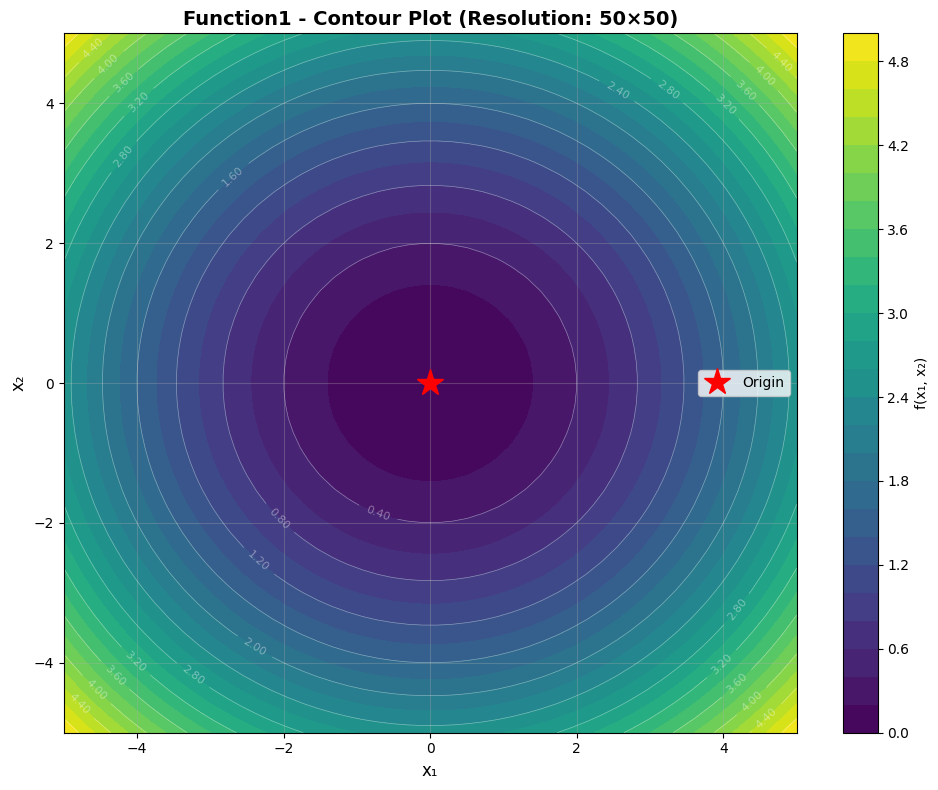


Creating contour plot for Function2
Resolution: 50×50 = 2500 API calls
Progress: 0/50 rows evaluated...
Progress: 10/50 rows evaluated...
Progress: 20/50 rows evaluated...
Progress: 30/50 rows evaluated...
Progress: 40/50 rows evaluated...
✅ Evaluation complete!
💾 Saved plot to: contour_function2_res50.png


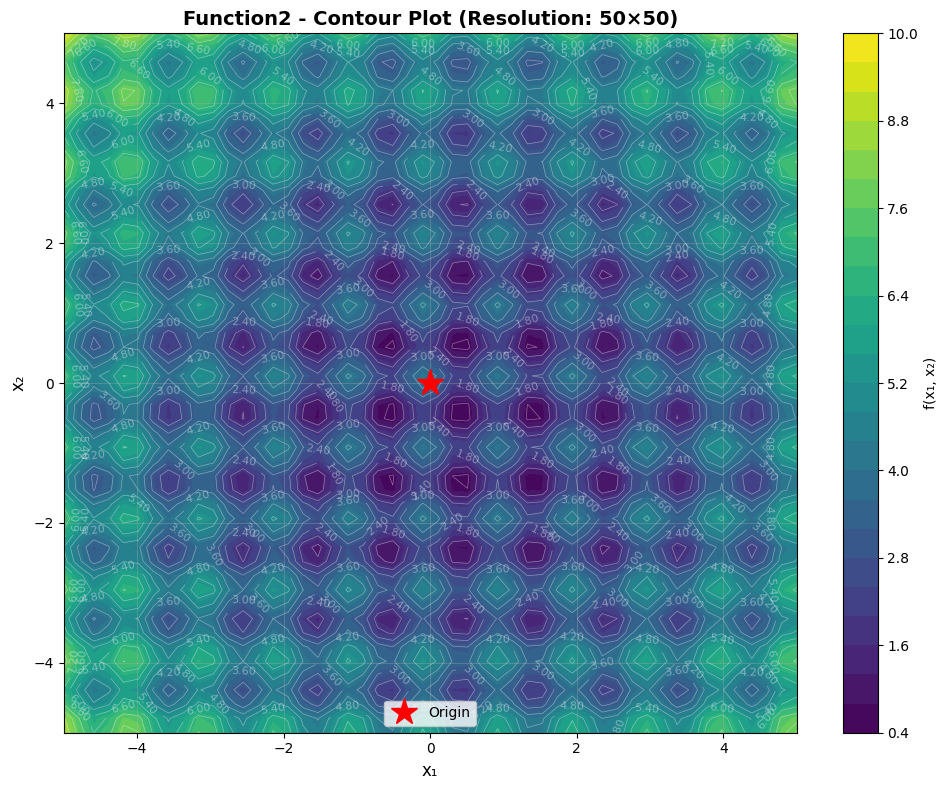


Creating contour plot for Function3
Resolution: 50×50 = 2500 API calls
Progress: 0/50 rows evaluated...
Progress: 10/50 rows evaluated...
Progress: 20/50 rows evaluated...
Progress: 30/50 rows evaluated...
Progress: 40/50 rows evaluated...
✅ Evaluation complete!
💾 Saved plot to: contour_function3_res50.png


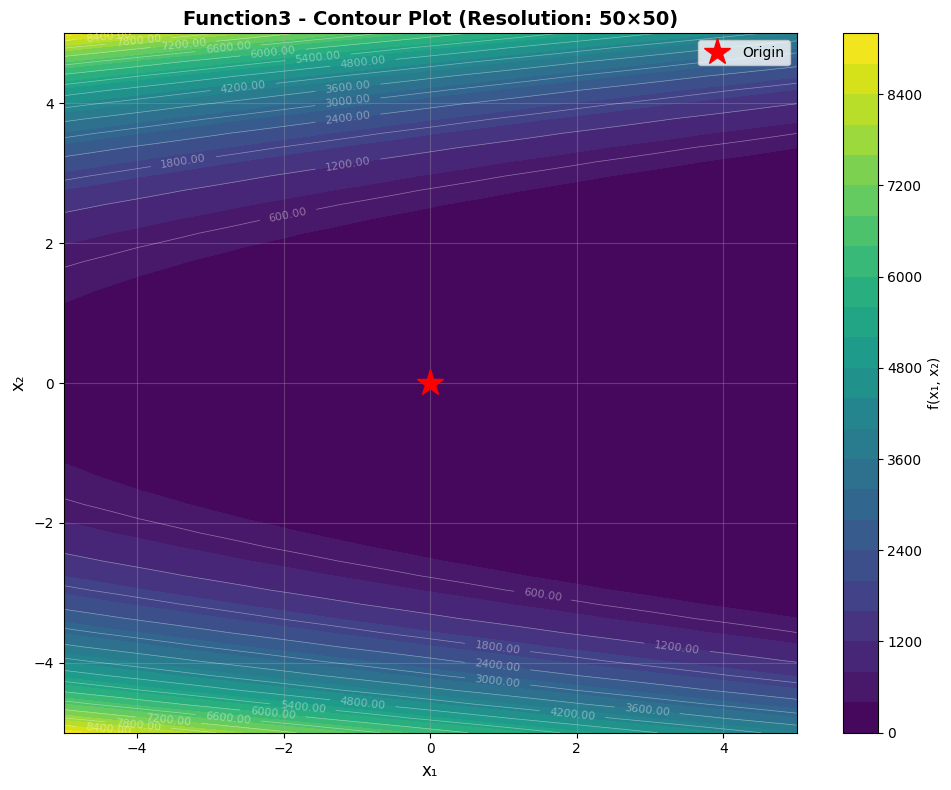


Creating contour plot for Function4
Resolution: 50×50 = 2500 API calls
Progress: 0/50 rows evaluated...
Progress: 10/50 rows evaluated...
Progress: 20/50 rows evaluated...
Progress: 30/50 rows evaluated...
Progress: 40/50 rows evaluated...
✅ Evaluation complete!
💾 Saved plot to: contour_function4_res50.png


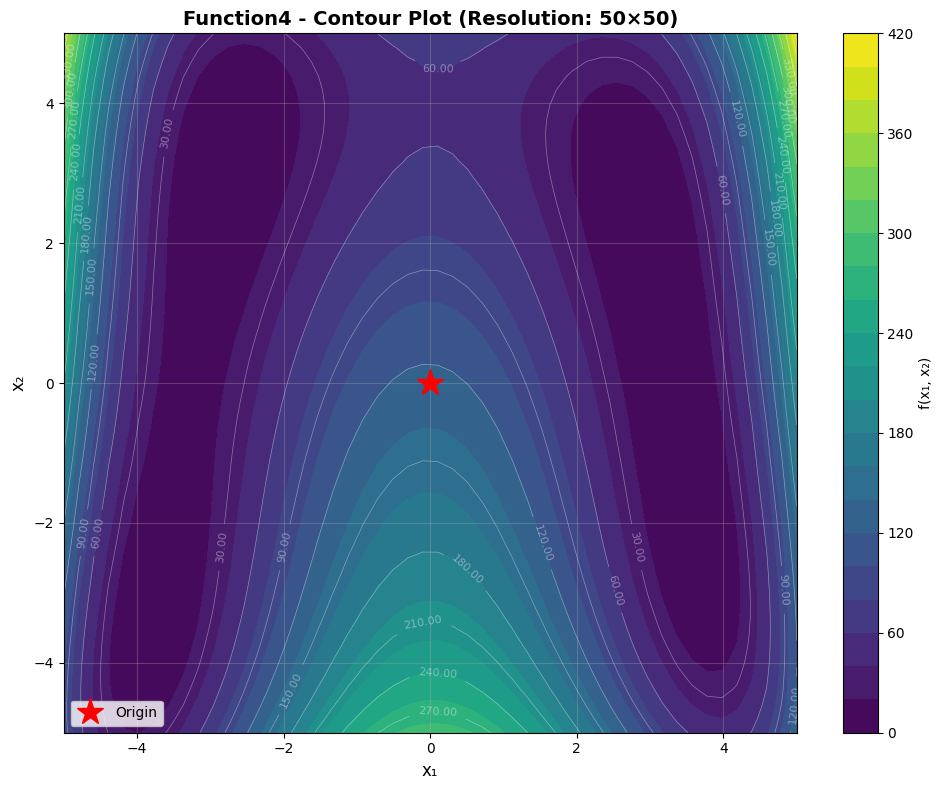


Creating contour plot for Function5
Resolution: 50×50 = 2500 API calls
Progress: 0/50 rows evaluated...
Progress: 10/50 rows evaluated...
Progress: 20/50 rows evaluated...
Progress: 30/50 rows evaluated...
Progress: 40/50 rows evaluated...
✅ Evaluation complete!
💾 Saved plot to: contour_function5_res50.png


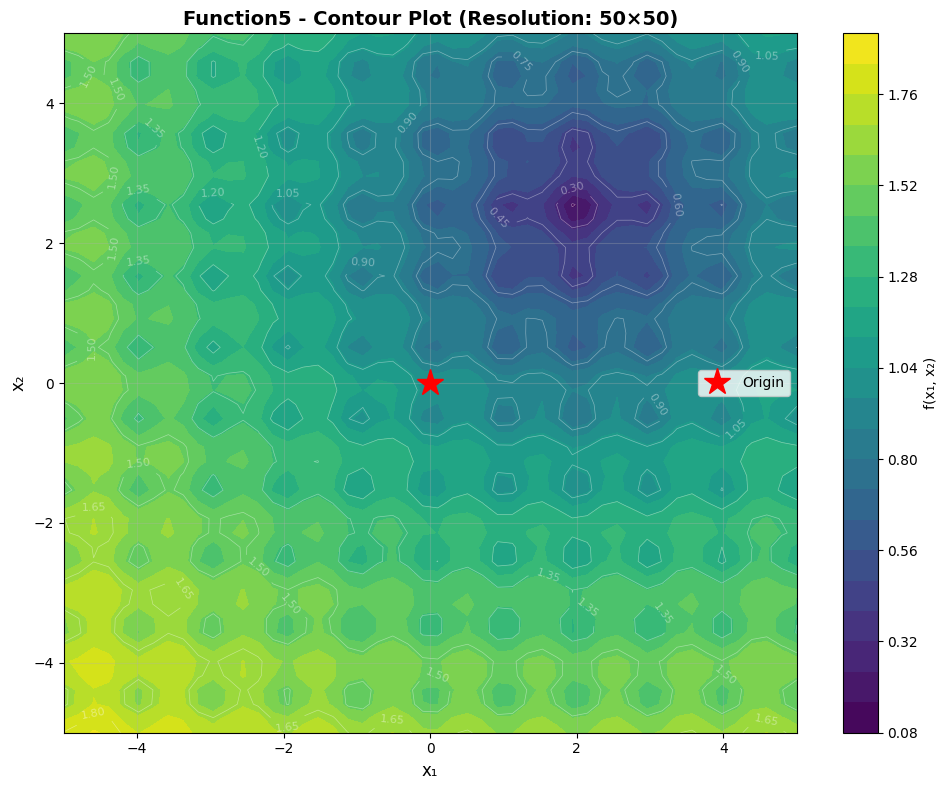


✅ Completed 5/5 contour plots!


In [45]:
# Generate contour plots for all 5 functions
# Resolution 50 = 2500 API calls per function × 5 functions = 12,500 total API calls
# This will take a while!

contour_results = create_all_contour_plots(
    bb=bb, 
    functions=functions,
    resolution=50,
    save_plots=True
)